# Avatar generator with generative deep learning  

Afin de proposer un service de génération automatique d'avatar, la société Dupond Père et Fils vous mandate afin de développer l'application.

Pour ce faire, vous disposez d'un jeux de données d'avatars disponible ici (utilisez celui de 10000 images) :  
* https://google.github.io/cartoonset/download.html  

L'opérateur souhaite utiliser une technologie de modèle profond génératif de type GAN. De plus, celui-ci dispose de ressources limitées, il vous est demandé de redimensioner les images en 128x128 pixels.  

On vous demande de réaliser les éléments suivants :  
* Designer le système d'apprentissage afin de produire un modèle entrainé pour le service de génération d'avatar  
* Créer une application web permettant de générer des avatars  
* Afficher par défaut sur une même page 10x8 avatars (10 lignes x 8 colonnes)  
* Avec un bouton permettant de régénérer les avatars  

**Bonus** : développer un modèle alternatif utilisant un modèle type Variational Auto-Encoder (VAE)

**Durée** : 2 jours

**Discord Red** ['Nidhal', 'Caroline', 'Olivier', 'Myriam', 'Sacia', 'Jean-Pierre', 'Fatima']  

**Ressources** :

* Page 305 du livre ***Deep Learning with Python*** de Francois Chollet  
* https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/  
* https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/  
* https://keras.io/examples/generative/dcgan_overriding_train_step/  
* https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889  


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import os
import pprint

pp = pprint.PrettyPrinter(indent=4)

In [2]:
import joblib
from PIL import Image
from skimage.io import imread
from skimage.transform import resize

def resize_avatars(src, pklname, include, width=128, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: int
        samples to include
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'avatars resized in {0}x{1} px RGB'.format(int(width), int(height))
    data['filename'] = []
    data['avatar'] = []
     
    pklname = f"./records/{pklname}_{width}x{height}px.pkl"
    avatars_path = os.listdir(src)
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for file in avatars_path[:include]:
        im = Image.open(os.path.join(src, file))
        rgb_im = np.array(im.convert('RGB'))
        im = resize(rgb_im, (width, height)) #[:,:,::-1]
        data['filename'].append(file)
        data['avatar'].append(im)
    joblib.dump(data, pklname)


In [3]:
# modify to fit your system
data_path = fr'{os.getenv("HOME")}/Briefes/DL/20210323_Avatar_Generator/data/cartoonset10k-png'
print('Number of avatars in data path =', len(os.listdir(data_path)))

Number of avatars in data path = 10000


In [4]:
# File name
base_name = 'avatars'
# Image size in px
width = 32
# Number of samples (avatars) to include
include = 2000

resize_avatars(src=data_path, pklname=base_name, include=include, width=width)

In [5]:
data_set = joblib.load(f'./records/{base_name}_{width}x{width}px.pkl')

print('DATA SET')
print('Description\t\t', data_set['description'])
print('Keys\t\t\t', list(data_set.keys()))
print('Number of avatars\t', len(data_set['avatar']))
print('Avatar shape\t\t', data_set['avatar'][0].shape)


DATA SET
Description		 avatars resized in 32x32 px RGB
Keys			 ['description', 'filename', 'avatar']
Number of avatars	 2000
Avatar shape		 (32, 32, 3)


## GAN Generative Adversarial Networks

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

## The Generator

In [7]:
generator_input = keras.Input(shape=(latent_dim,))

# Transform the input into a 16 × 16 128-channel feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsamples to 32 × 32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produces a 32 × 32 1-channel feature map (shape of a AVATAR image)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
# Instantiates the generator model which maps ...
# The input of shape (latent_dim,) into an image of shape (32, 32, 3)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

## The Discriminator

In [8]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# IMPORTANT TRICK !!! One dropout layer
x = layers.Dropout(0.5)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

# Instantiate the discriminator model, which turns a (32, 32, 3) input
# into a binary classification decision (fake/real)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

In [9]:
discriminator_optimizer = keras.optimizers.RMSprop(
    # Learning Rate
    lr=0.0008,
    # Use gradient clipping (by value) in the optimizer
    clipvalue=1.0,
    # Use learning-rate DECAY to stabilize training
    decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

## The Adversarial Network

In [10]:
# This will ONLY apply to the GAN model
# Sets discriminator weights to non-trainable
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## GAN training

In [11]:
# Load AVATARS data set
X_train = np.array(data_set['avatar'])
print('X_train', X_train.shape)
print(list(X_train[0]))

X_train (2000, 32, 32, 3)
[array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
     

In [12]:
import os
from tensorflow.keras.preprocessing import image
import time
from datetime import datetime
import pandas as pd

iterations = 300
batch_size = 16
save_dir = './generated-avatars'

start = 0
results = []

for step in range(iterations):
    # GENERATED avatars
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)

    # REAL avatars
    stop = start + batch_size
    real_images = X_train[start: stop]

    # Mix of REAL & GENERATED avatars + NOISE
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    
    # LOSSES computation
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    # LOSSES recording
    dict_temp = {}
    dict_temp = {
        'epoch': step,
        'd_loss': d_loss,
        'a_loss': a_loss,
    }
    results.append(dict_temp)
    
    start += batch_size
    if start > len(X_train) - batch_size:
        start = 0
    if step % 10 == 0:
        gan.save_weights('./records/gan.h5')
        print('Epoch', step)
        print('DISCRIMINATOR loss\t', d_loss)
        print('ADVERSARIAL loss\t', a_loss)
        print('----------------------------------------------')
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_avatar' + str(step) + '.png'))
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_avatar' + str(step) + '.png'))

results = pd.DataFrame(results)
results.to_csv('./records/GAN-loss-history.csv', encoding='utf-8')

Epoch 0
DISCRIMINATOR loss	 0.6738121509552002
ADVERSARIAL loss	 0.6593555808067322
----------------------------------------------
Epoch 10
DISCRIMINATOR loss	 0.6154646277427673
ADVERSARIAL loss	 0.8470362424850464
----------------------------------------------
Epoch 20
DISCRIMINATOR loss	 0.44942009449005127
ADVERSARIAL loss	 2.645345687866211
----------------------------------------------
Epoch 30
DISCRIMINATOR loss	 0.5896459817886353
ADVERSARIAL loss	 3.057069778442383
----------------------------------------------
Epoch 40
DISCRIMINATOR loss	 0.46074187755584717
ADVERSARIAL loss	 0.7927549481391907
----------------------------------------------
Epoch 50
DISCRIMINATOR loss	 0.5755075812339783
ADVERSARIAL loss	 0.8435015678405762
----------------------------------------------
Epoch 60
DISCRIMINATOR loss	 0.5092431306838989
ADVERSARIAL loss	 1.477160096168518
----------------------------------------------
Epoch 70
DISCRIMINATOR loss	 0.6326754689216614
ADVERSARIAL loss	 2.1179611682

In [13]:
results.to_csv('./records/GAN-loss-history.csv', encoding='utf-8')

In [82]:
plt.style.use('ggplot')

#def plot_history(df, *ylim):
def plot_history(df):
    x = df['epoch']
    d_loss = df['d_loss']
    a_loss = df['a_loss']

    plt.figure(figsize=(20, 10))
    plt.title('LOSS')
    #plt.axes(xlabel='epoch', ylabel='loss', ylim=ylim)
    plt.axes(xlabel='epoch', ylabel='loss')

    plt.plot(x, d_loss, 'b', label='DISCRIMINATOR')
    plt.plot(x, a_loss, 'r', label='GENERATOR')

    plt.legend()
    plt.show()

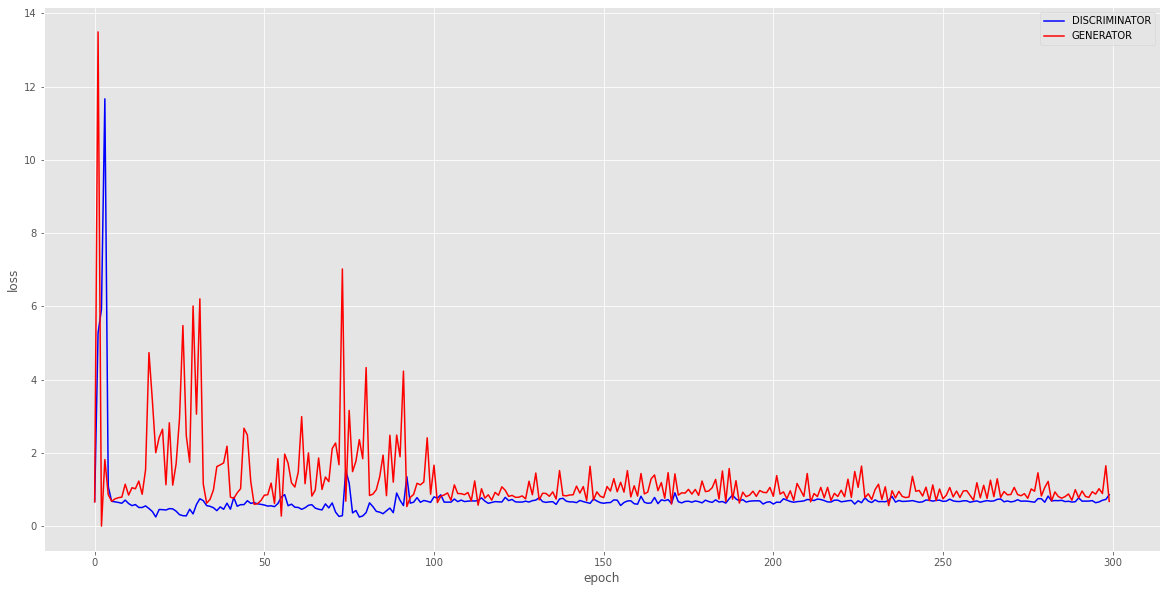

In [83]:
df = pd.read_csv('./records/GAN-loss-history.csv')
plot_history(df)